In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from backtest import BackTester

In [2]:
# EXAMPLE STRATEGIES

def mock_decision(prices, ratios):
    return pd.Series({prices['permno'].iloc[0]:.5, prices['permno'].iloc[-1]:.5})

def easy_momentum(prices, ratios, count=50):
    returns = prices.pivot(index='date', values='ret', columns='permno') + 1
    period_returns = returns.cumprod().iloc[-1]
    top_stocks = period_returns.nlargest(count).index
    return pd.Series({stock:1/len(top_stocks) for stock in list(top_stocks)})

def entire_market(prices, ratios):
    all_stocks = prices['permno'].unique()
    return pd.Series({s:1/len(all_stocks) for s in all_stocks})

100%|██████████| 393/393 [00:02<00:00, 156.10it/s]


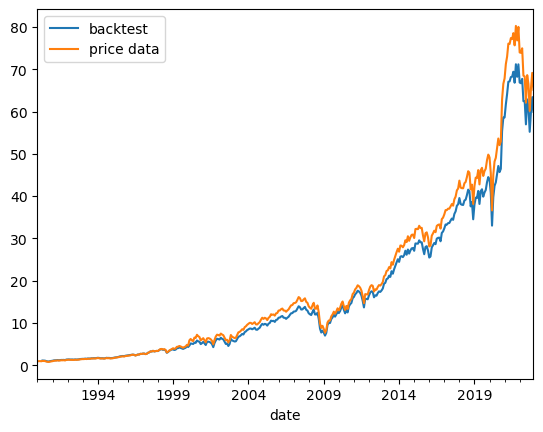

In [3]:
# SANITY TEST
# COMPARE ENTIRE MARKET STRATEGY TO SIMPLE CALCULATIONS ON THE PRICES DATA

backtester = BackTester()
backtester.rolling_test(decision_function=entire_market, n_prices=3, frequency=1)

prices = pd.read_pickle('data/cleaned_prices.pkl')
prices = (prices.pivot(columns='permno', index='date', values='ret').mean(axis=1) + 1).cumprod()


fig, ax = plt.subplots()
backtester.results.cumprod().plot(ax=ax, label='backtest')
prices.plot(ax=ax, label='price data')
ax.legend()

# performs slightly worse ?? still passes the sanity test imo.
# probably missing price or financial data for some stocks 
# which end up getting taken out by DataFetcher

In [4]:
# Eriks mega cluster momentum

In [5]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer

In [33]:
def _get_cluster(ratios):
    X = ratios.copy()
    X = X.set_index('permno')
    X = X.drop('date', axis=1)
    X = Normalizer().transform(X=X.values)
    X = PCA(n_components=0.95).fit_transform(X)
    X = KMeans(n_clusters=15, n_init='auto').fit(X).labels_
    clusters = pd.Series(X, index=ratios['permno'])
    return clusters


def _get_returns(prices):
    X = prices.copy()
    X['returns'] = X['ret'] +1
    returns = X.groupby('permno')['returns'].prod()
    return returns


def _get_n_stocks(n, cluster_returns):
    return (
        cluster_returns
        .groupby('cluster')['returns']
        .nlargest(n)
        .reset_index()['permno']
    )


def _sharpe_ratio(prices):
    # Calculate the mean and standard deviation of the returns of each stock
    mean_returns = prices.mean()
    # Calculate the covariance matrix of the returns
    cov_matrix = prices.cov()
    # Calculate the overall mean and standard deviation of the portfolio returns
    portfolio_mean = mean_returns.mean()
    portfolio_std = np.sqrt(np.dot(
        np.dot(np.array([1]*len(mean_returns)), cov_matrix),
        np.array([1]*len(mean_returns)).T)) / len(mean_returns)
    # Calculate the Sharpe ratio of the portfolio
    sharpe_ratio = (portfolio_mean / portfolio_std)
    return sharpe_ratio


def _select_stocks(prices, cluster_returns):
    returns = prices.pivot(columns='permno', index='date', values='ret')
    n=1
    sharpe = -1000
    while True:
        stocks = _get_n_stocks(n, cluster_returns=cluster_returns)
        _sharpe = _sharpe_ratio(returns[stocks])
        if _sharpe>sharpe:
            final_picks=stocks
            sharpe=_sharpe
            n+=1
        else:
            break
    return final_picks


def strategy(prices, ratios):
    cluster_returns = pd.DataFrame({
        'cluster':_get_cluster(ratios=ratios),
        'returns':_get_returns(prices=prices)
        })

    stocks = _select_stocks(
        prices=prices,
        cluster_returns=cluster_returns
        )

    return pd.Series({s:1/len(stocks) for s in stocks})

In [34]:
backtester = BackTester()
backtester.rolling_test(decision_function=strategy, n_prices=5, frequency=1)

100%|██████████| 391/391 [00:20<00:00, 18.99it/s]


<AxesSubplot: >

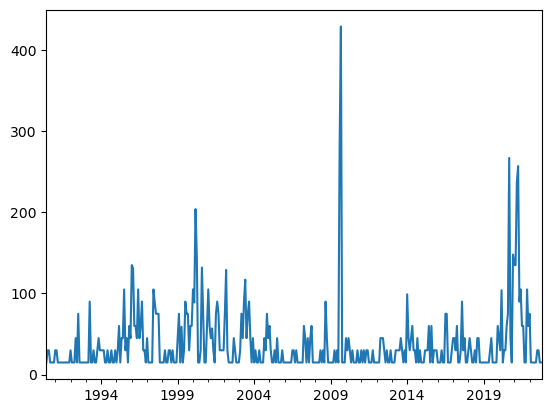

In [36]:
backtester.investments['allocs'].apply(len).plot()

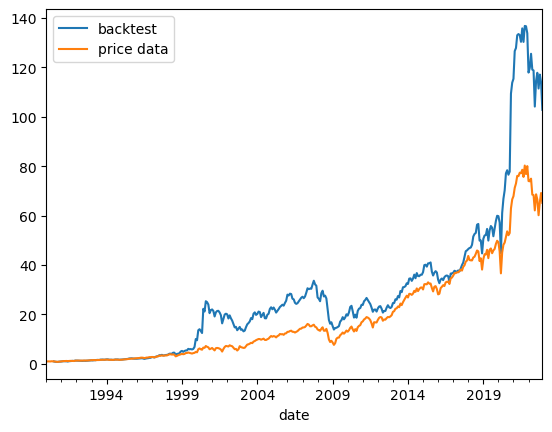

In [37]:
prices = pd.read_pickle('data/cleaned_prices.pkl')
prices = (prices.pivot(columns='permno', index='date', values='ret').mean(axis=1) + 1).cumprod()


fig, ax = plt.subplots()
backtester.results.cumprod().plot(ax=ax, label='backtest')
prices.plot(ax=ax, label='price data')
ax.legend()

In [38]:
backtester.analyse()

Mean returns           0.015
Standard deviation     0.083
Sharpe                 0.181
Skew                   3.073
Kurtosis              24.600
dtype: float64